# ModOAP - Textométrie

Ce script propose des outils de textométrie utilisables sur un corpus de textes en format structuré, téléchargés via le script [ModOAP_Telechargement_structure_texte_doc_Gallica](https://github.com/MODOAP/Telechargement_structure_texte_doc_Gallica)

Le corpus est attendu sous la forme d'un dossier sur un Google Drive contenant un fichier .json par document du corpus.

Le corpus doit être pré-traité lors de la première utilisation grâce à la cellule **Prétraiter un dossier corpus**.



# Préparation du corpus et imports




In [ ]:
#@markdown # Préparation du script et synchronisation d'un Google Drive

#@markdown Lancer cette cellule, puis cliquer sur le lien généré par Google pour connecter un compte Drive si demandé.

#@markdown Cette cellule télécharge notamment le modèle fr_core_news_lg de la bibliothèque Spacy, ce qui peut prendre plusieurs minutes en fonction de la connexion internet.


# chargement d'un google drive
import os
import pickle
import re
from google.colab import drive

if not os.path.exists("/content/drive/MyDrive/") :
  drive.mount('/content/drive/')

!pip install -q -U spacy
import spacy
from spacy.tokens import DocBin

try : 
  import fr_core_news_lg
except ModuleNotFoundError :
  !python -m spacy download fr_core_news_lg
  import fr_core_news_lg

nlp = fr_core_news_lg.load() 
nlp = spacy.load("fr_core_news_lg", disable=["attribute_ruler", "textcat_multilabel", "textcat", "ner", "entity_linker", "entity_ruler", "entity_linker"])
nlp.max_length = 1500000

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.probability import FreqDist

import matplotlib.pyplot as plt

import numpy as np
import json
import glob
import pandas as pd
import altair as alt
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

try :
  from colorama import Fore, Back, Style
except ModuleNotFoundError :
  !pip install colorama
  from colorama import Fore, Back, Style



def lemmatisation(doc):
  lemmes = [mot.lemma_ for mot in doc if mot.pos_ is not "PUNCT" and mot.pos_ is not "SPACE"]
  return lemmes
  
def stopwords_filter(doc):
  mots_grammaticaux = set(stopwords.words('french'))
  add = ["aussi", "quelque", "quelques", "tel", "telle", "telles", "tels", "y"]
  for mot in add :
    mots_grammaticaux.add(mot)
  POS_filter = ["SPACE", "ADP", "DET", "CCONJ", "PUNCT", "NUM", "PRON"]
  chars = list(set('$,./?\;\'\'\’\’\\^')) + ["\n","\xa0"]
  mots_lexicaux = [mot for mot in doc if len(mot.text) > 1 and mot.text.lower() not in mots_grammaticaux and not any(pos in mot.pos_ for pos in POS_filter) and not any((c in chars) for c in mot.text)]
  return mots_lexicaux

def lemma_stopwords_filter(doc):
  mots_grammaticaux = set(stopwords.words('french'))
  add = ["aussi", "quelque", "quelques", "tel", "telle", "telles", "tels"]
  for mot in add :
    mots_grammaticaux.add(mot)
  POS_filter = ["SPACE", "ADP", "DET", "CCONJ", "PUNCT", "NUM", "PRON"]
  chars = list(set('$,./?\;\'\'\’\’\\^')) + ["\n","\xa0"]
  mots_lexicaux = [mot.lemma_ for mot in doc if len(mot.text) > 1 and mot.text.lower() not in mots_grammaticaux and not any(pos in mot.pos_ for pos in POS_filter) and not any((c in chars) for c in mot.text)]
  return mots_lexicaux 

def premier_filtre(doc):
  POS_filter = ["SPACE", "PUNCT"]
  chars = list(set('$,./?\;\'\'\’\’\\^')) + ["\n","\xa0"]
  mots_filtres = [mot for mot in doc if len(mot.text) > 1 and not any((c in chars) for c in mot.text) and not any(pos in mot.pos_ for pos in POS_filter)]
  return mots_filtres

def json2dict(jsonfile) :
  with open(jsonfile, "r") as json_in :
    dictjson = json.load(json_in)
  return dictjson

def nettoyage_bloc(bloc):
  bloc = bloc.replace(" fig ", "")
  bloc = bloc.replace(" do ", " de ")
  bloc = bloc.replace(" dos ", " des ")
  bloc = bloc.replace(" * ", "")
  bloc = bloc.replace(" k ", "")
  bloc = bloc.replace("«", "")
  bloc = bloc.replace("»", "")
  bloc = bloc.replace(" lo ", " le ")
  bloc = bloc.replace(" los ", " les ")
  bloc = bloc.replace(" ot ", " et ")
  bloc = bloc.replace(" ôt ", " et ")
  bloc = bloc.replace("- ", "")
  bloc = bloc.replace(" - ", "")
  bloc = bloc.replace("  ", " ")
  bloc = bloc.replace("   ", " ")
  bloc = bloc.replace(" so ", " se ")
  bloc = bloc.replace(" quo ", " que ")
  bloc = bloc.replace(" Ello ", " Elle ")
  bloc = bloc.replace(" ello ", " elle ")
  bloc = bloc.replace(" villo ", " ville ")
  bloc = bloc.replace(" ollo ", " elle ")
  bloc = bloc.replace(" uno ", " une ")
  bloc = bloc.replace(" Cotte ", " Cette ")

  return bloc


def pretraitements_paragraphe(dictjson) :
  docs = []
  for tb in dictjson["Text_Blocks"]:
    bloc = nettoyage_bloc(dictjson["Text_Blocks"][tb]["Content"])
    docs.append(nlp(bloc))
  doc_bin = DocBin(docs=docs)
  return doc_bin

def pre_traitement_dossier(chemin_dossier):
  doc_bins = []
  nlp_traites = [nlpfile for nlpfile in glob.glob(os.path.join(chemin_dossier,"*.nlp"))]
  for jsonfile in tqdm(glob.glob(os.path.join(chemin_dossier,"*.json"))) :
    if jsonfile[:-5]+".nlp" not in nlp_traites :
      dictjson = json2dict(jsonfile)
      doc_bin = pretraitements_paragraphe(dictjson)
      doc_bin.to_disk(jsonfile[:-5]+".nlp")
      doc_bins.append(pretraitements_paragraphe(dictjson))
  return doc_bins

In [ ]:
#@markdown # Prétraiter un dossier corpus

#@markdown #### Entrer le chemin du dossier contenant les fichiers .json à pré-traiter :
chemin_dossier = "" #@param {type:"string"}

#@markdown #### Cette cellule applique des pré-traitements linguistiques nécessaires aux calculs textométriques (segmentation et étiquetages).
#@markdown #### Elle crée un fichier .nlp par fichier .json dans le dossier spécifié.
#@markdown #### Si le pré-traitement a déjà été lancé et que les fichiers .nlp sont présents dans le dossier, la cellule peut être passée et le corpus pré-traité peut être importé dans la cellule suivante.

doc_bins_corpus = pre_traitement_dossier(chemin_dossier)

In [ ]:
#@markdown # Importer un dossier corpus prétraité:

#@markdown #### Entrer le chemin du dossier contenant les fichiers .nlp et .json :

chemin_dossier = "" #@param {type:"string"}

dico_corpus = {}

jsons = [fil for fil in glob.glob(os.path.join(chemin_dossier,"*.json"))]
nlpz = [fil for fil in glob.glob(os.path.join(chemin_dossier,"*.nlp"))]

for json_file in tqdm(jsons) :
  nlpfile = json_file[:-5]+".nlp"
  dict_man = json2dict(json_file)
  doc_bin = DocBin().from_disk(nlpfile)
  docs = list(doc_bin.get_docs(nlp.vocab))
  dict_man['Infos_Doc']['docs'] = docs
  dict_man['Infos_Doc']['nlp'] = nlpfile
  i = 0
  for tb in dict_man['Text_Blocks'] :
    dict_man['Text_Blocks'][tb]["Num_Paragraphe"] = i
    i+= 1
  dico_corpus[json_file] = dict_man

dico_corpus_ids = {}
for man in tqdm(dico_corpus) :
  i = 0
  infodoc = dico_corpus[man]["Infos_Doc"]
  tbz = {}
  for tb in dico_corpus[man]["Text_Blocks"] :
    tbz[i] = dico_corpus[man]["Text_Blocks"][tb]
    i+=1
  manew = {"Infos_Doc" : infodoc, "Text_Blocks" : tbz}
  dico_corpus_ids[man] = manew

dico_corpus = dico_corpus_ids

print()
print("{} documents importés".format(len(jsons)))

# Recherche par terme

In [ ]:
#@title # Choix des pré-traitements pour le calcul des occurrences les plus répandues

pretraitement = "lemmatisation+mots_grammaticaux" #@param ["lemmatisation", "mots_grammaticaux", "lemmatisation+mots_grammaticaux", "aucun"]

#@markdown #### mots_grammaticaux = filtre des mots grammaticaux autres que les noms, adjectifs, verbes, participes et adverbes
#@markdown #### lemmatisation = généralisation des verbes à leur forme infinitive et des noms, pronoms, déterminants et adjectifs au masculin singulier

tokens_corpus = []

for man in tqdm(dico_corpus) :
  docs = dico_corpus[man]["Infos_Doc"]["docs"]
  compteur_paragraphes = 0
  for doc in docs :
    if pretraitement == "mots_grammaticaux":
      tokens_corpus = tokens_corpus + stopwords_filter(doc)
    elif pretraitement == "lemmatisation":
      tokens_corpus = tokens_corpus + lemmatisation(doc)
    elif pretraitement == "lemmatisation+mots_grammaticaux":
      tokens_corpus = tokens_corpus + lemma_stopwords_filter(doc)
    elif pretraitement == "aucun":
      mots = [mot for mot in doc]
      tokens_corpus = tokens_corpus + mots
  compteur_paragraphes +=1

print("Les pré-traitements ont été opérés")

In [ ]:
#@markdown # Fréquences des termes les plus présents dans le corpus

#@markdown #### Cette cellule calcule le nombre d'occurrences des N termes les plus présents dans le corpus.
#@markdown #### Spécifier le nombre de termes à afficher :

nombre_termes =  20#@param {type:"integer"}

#@markdown #### Les pré-traitements opérés sont ceux choisis dans la cellule précédente.

      
try :
  fdist = FreqDist([tok.text for tok in tokens_corpus])
except AttributeError :
  fdist = FreqDist([tok for tok in tokens_corpus])

fdist1 = fdist.most_common(nombre_termes)
mots = [mot[0] for mot in fdist1]
freqz = [mot[1] for mot in fdist1]
dicres = {"mot" : mots, "frequence" : freqz}
dfres = pd.DataFrame(dicres)

alt.Chart(dfres).mark_bar().encode(alt.X('mot:N', sort=alt.EncodingSortField(field="mot", op="count", order='ascending')),alt.Y('frequence'), tooltip ="frequence")


In [ ]:
#@title ## Evolution du nombre d'occurrences de termes au fil du temps

#@markdown #### Cette cellule calcule le nombre d'occurrences d'un ou plusieurs termes en fonction des années de publication des documents du corpus. 
#@markdown #### Les termes en requêtes tiennent compte des accents mais pas des majuscules. Pas de lemmatisation. 


terme_1 = ""#@param {type:"string"}
terme_2 = ""#@param {type:"string"}
terme_3 = ""#@param {type:"string"}
terme_4 = ""#@param {type:"string"}

requetes = [terme.lower() for terme in [terme_1,terme_2,terme_3,terme_4] if terme]

dico_corpus = dico_corpus_ids

annees = []
scores = []
termes = []
resultats0 = {}
resultats1 = {}
resultats3 = {}
resultats2 = {}

for man in tqdm(dico_corpus) :
  
  nlpfile = dico_corpus[man]["Infos_Doc"]["nlp"]
  doc_bin = DocBin().from_disk(nlpfile)
  docs = list(doc_bin.get_docs(nlp.vocab))
  for doc in docs :
    for mot in doc :
      if mot.text.lower() in requetes :
        id_req = int([i for i,x in enumerate(requetes) if x == mot.text.lower()][0])
        annee = dico_corpus[man]["Infos_Doc"]["Publication_Date"]
        if len(annee) > 4 :
          annee = annee[:4]

        if id_req == 0 :
          try :
            resultats0[annee] = resultats0[annee] + 1
          except KeyError :
            resultats0[annee] = 1
        elif id_req == 1 :
          try :
            resultats1[annee] = resultats1[annee] + 1
          except KeyError :
            resultats1[annee] = 1
        elif id_req == 2 :
          try :
            resultats2[annee] = resultats2[annee] + 1
          except KeyError :
            resultats2[annee] = 1
        elif id_req == 3 :
          try :
            resultats3[annee] = resultats3[annee] + 1
          except KeyError :
            resultats3[annee] = 1

termes_total = []
annees_total = []
scores_total = []
id = 0
for dict_res in [resultats0,resultats1,resultats2,resultats3] :
  if dict_res :
    annees = sorted([int(x) for x in dict_res.keys()])
    scores = [dict_res[str(annee)] for annee in annees]
    termes = [requetes[id]] * len(annees)
    termes_total = termes_total + termes
    annees_total = annees_total + annees
    scores_total = scores_total + scores
    id += 1 
df = {'terme': termes_total, 'annee': annees_total, "occurrences" : scores_total}
df_requete = pd.DataFrame(data=df)

alt.Chart(df_requete).mark_line().encode(
    x='annee',
    y='occurrences',
    color='terme',
    strokeDash='terme',
)


In [ ]:
#@title ## Calcul des cooccurrences pour un terme

#@markdown #### Cette cellule calcule les fréquences des cooccurrences d'un terme donné en requête, à l'échelle de la phrase.

#@markdown #### Spécifier un terme en requête, la direction du voisinage (à gauche ou à droite du terme dans le document), et le nombre de cooccurrences les plus fréquentes à afficher :



requete = ""#@param {type:"string"}

#@markdown #### Le terme en requête tient compte des accents mais pas des majuscules. Pas de lemmatisation. 


voisinage = "gauche_et_droit" #@param ["gauche", "droit", "gauche_et_droit"]
nb_cooc = 30#@param {type:"integer"}

requete = requete.lower()

#@markdown #### Pré-traitement opéré : filtre des mots grammaticaux uniquement.

voisinage_droit = []
voisinage_gauche = []

for man in tqdm(dico_corpus) :
  docs = dico_corpus[man]["Infos_Doc"]["docs"]
  compteur_paragraphes = 0
  for doc in docs :
    for mot in doc :
      if mot.text.lower() == requete :
        if "droit" in voisinage : 
          voisinage_droit = voisinage_droit + [w.text for w in mot.rights if w.is_stop == False and w.pos_ not in ["PUNCT"]]

        if "gauche" in voisinage : 
          voisinage_gauche = voisinage_gauche + [w.text for w in mot.lefts if w.is_stop == False and w.pos_ not in ["PUNCT"]]
    
      compteur_paragraphes += 1

if voisinage == "gauche" :
  fdist = FreqDist(voisinage_gauche)
elif voisinage == "droit" :
  fdist = FreqDist(voisinage_droit)
elif voisinage == "gauche_et_droit" :
  fdist = FreqDist(voisinage_gauche+voisinage_droit)

fdist1 = fdist.most_common(nb_cooc)
mots = [mot[0] for mot in fdist1]
freqz = [mot[1] for mot in fdist1]
dicres = {"mot" : mots, "frequence" : freqz}
dfres = pd.DataFrame(dicres)
alt.Chart(dfres).mark_bar().encode(alt.X('mot:N', sort=alt.EncodingSortField(field="mot", op="count", order='ascending')),alt.Y('frequence'), tooltip ="frequence")



In [ ]:
#@title ## Calcul des cooccurrences pour un terme en fonction des relations syntaxiques 

#@markdown #### Cette cellule calcule les fréquences des cooccurrences liées syntaxiquement à un terme donné en requête, à l'échelle de la phrase.

#@markdown #### Spécifier un terme en requête, le nombre de cooccurrences les plus fréquentes à afficher, et la nature de la relation syntaxique souhaitée :

requete = ""#@param {type:"string"}
requete = requete.lower()
nb_cooc = 30#@param {type:"integer"}
relation = "dependants_syntaxiques" #@param ["tete_syntaxique", "dependants_syntaxiques"]

#@markdown #### La relation dépendants_syntaxiques affiche les cooccurrences qui dépendent de la requête (ex : un adjectif qualificatif qui dépend d'un nom)
#@markdown #### La relation tete_syntaxique affiche les cooccurrences dont dépend la requête (ex : un nom dont dépend un adjectif ou un verbe dont dépend un nom)
termes_lies = []

for man in tqdm(dico_corpus) :
  docs = dico_corpus[man]["Infos_Doc"]["docs"]
  for doc in docs :
    for mot in doc :
      #if mot.pos_ == "ADJ":
      if mot.text.lower() == requete:
        if relation == "dependants_syntaxiques" :
          termes_lies = termes_lies + [child.text for child in mot.children if child.is_stop == False if child.is_alpha == True]
        elif relation == "tete_syntaxique":
          termes_lies = termes_lies + [ancestor.text for ancestor in mot.ancestors if ancestor.is_stop == False if ancestor.is_alpha == True]

fdist = FreqDist(termes_lies)
fdist1 = fdist.most_common(nb_cooc)
mots = [mot[0] for mot in fdist1]
freqz = [mot[1] for mot in fdist1]
dicres = {"mot" : mots, "frequence" : freqz}
dfres = pd.DataFrame(dicres)
alt.Chart(dfres).mark_bar().encode(alt.X('mot:N', sort=alt.EncodingSortField(field="mot", op="count", order='ascending')),alt.Y('frequence'), tooltip ="frequence")

      

In [ ]:
#@title ## Calcul des syntagmes nominaux les plus fréquents contenant un terme donné

#@markdown #### Cette cellule affiche les syntagmes nominaux (groupes nominaux étendus) les plus fréquents contenant un terme donné en requête.
#@markdown #### Permet notamment d'observer dans quels groupes nominaux un nom est utilisé.
#@markdown #### Spécifier un nom en requête, et le nombre de syntagmes nominaux les plus fréquents à afficher. 

requete = ""#@param {type:"string"}

#@markdown #### La requête tient compte des accents et des majuscules.


nb_termes = 10#@param {type:"integer"}

nounchunks = []

for man in tqdm(dico_corpus) :
  docs = dico_corpus[man]["Infos_Doc"]["docs"]
  for doc in docs :
    for chunk in doc.noun_chunks:
      for mot in chunk :
        if requete == mot.text :
          nounchunks.append(chunk.text)

print()
fdist = FreqDist(nounchunks)
fdist1 = fdist.most_common(nb_termes)
mots = [mot[0] for mot in fdist1]
freqz = [mot[1] for mot in fdist1]
dicres = {"mot" : mots, "frequence" : freqz}
dfres = pd.DataFrame(dicres)
alt.Chart(dfres).mark_bar().encode(alt.X('mot:N', sort=alt.EncodingSortField(field="mot", op="count", order='ascending')),alt.Y('frequence'), tooltip ="frequence")

# Recherche par patrons morphosyntaxiques

Construire le patron dans la première cellule avant de lancer le calcul des fréquences et l'affichage des concordances.

Entrer dans le premier champ de texte un patron composé de 1 à 4 termes (mot, lemme ou catégorie grammaticale) séparés par un espace.

Puis sélectionner le type de chaque terme 

TEXT = un mot précis

LEMMA = un lemme

POS = une catégorie grammaticale selon le code Universal Dependencies

VIDE = si inexistant

Liste des catégories Universal Dependencies (https://universaldependencies.org/u/pos/) :     

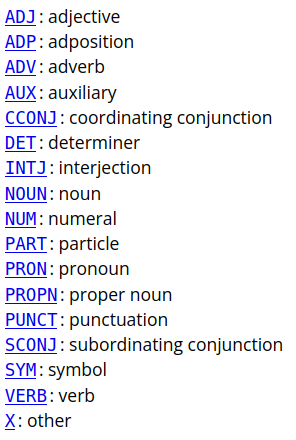

In [ ]:
#@title ## Construction du patron { form-width: "20%" }

#@markdown #### Entrer un patron composé de 1 à 4 termes (mot, lemme ou catégorie grammaticale) séparés par un espace :

pattern = []
dico_corpus = dico_corpus_ids
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)
patron = "le ADJ fille" #@param {type:"string"}

#@markdown #### Sélectionner le type de chaque terme, VIDE si inexistant :

type_1 = "LEMMA" #@param ["TEXT", "LEMMA", "POS"]
type_2 = "POS" #@param ["TEXT", "LEMMA", "POS", "VIDE"]
type_3 = "LEMMA" #@param ["TEXT", "LEMMA", "POS", "VIDE"]
type_4 = "VIDE" #@param ["TEXT", "LEMMA", "POS", "VIDE"]

patron = [token for token in patron.split(" ")]

if type_1 != "VIDE":
  if type_1 == "POS" :
    dict_token = {type_1:patron[0]}
  else :
    dict_token = {type_1:patron[0].lower()}
  pattern.append(dict_token)
if type_2 != "VIDE":
  if type_2 == "POS" :
    dict_token = {type_2:patron[1]}
  else :
    dict_token = {type_2:patron[1].lower()}
  pattern.append(dict_token)
if type_3 != "VIDE":
  if type_3 == "POS" :
    dict_token = {type_3:patron[2]}
  else :
    dict_token = {type_3:patron[2].lower()}
  pattern.append(dict_token)
if type_4 != "VIDE":
  if type_4 == "POS" :
    dict_token = {type_4:patron[3]}
  else :
    dict_token = {type_4:patron[3].lower()}
  pattern.append(dict_token)

matcher.add("custom", [pattern])
print(pattern)


#@markdown #### **Exemple** : 
#@markdown #### **patron** : "le ADJ fille"
#@markdown #### **type_1** : LEMMA
#@markdown #### **type_2** : POS
#@markdown #### **type_3** : LEMMA
#@markdown #### **type_4** : VIDE
#@markdown #### Permettra de repérer des segments comme ***la jeune fille*** ou ***les pauvres filles***.


In [ ]:
#@markdown ### Fréquences des segments correspondant au patron les plus répandus dans le corpus 

#@markdown #### Spécifier le nombre maximum de segments les plus répandus à afficher :
nombre_segments =  200#@param {type:"integer"}

patrons = []
compteur_matches = 0
  

for man in tqdm(dico_corpus) :
  docs = dico_corpus[man]["Infos_Doc"]["docs"]
  compteur_paragraphes = 0
  for doc in docs :

    matches = matcher(doc)
    
    for match_id, start, end in matches:
      string_id = nlp.vocab.strings[match_id]  # Get string representation
      span = doc[start:end]  # The matched span
      patrons.append(span.text)
  
    compteur_paragraphes += 1

print()
print(len(patrons), " segments repérés")

fdistpatron = FreqDist(patrons)
fdistpatron1 = fdistpatron.most_common(nombre_segments)

mots = [mot[0] for mot in fdistpatron1]
freqz = [mot[1] for mot in fdistpatron1]
dicres = {"mots" : mots, "frequence" : freqz}
dfres = pd.DataFrame(dicres)

alt.Chart(dfres).mark_bar().encode(alt.X('mots:N', sort=alt.EncodingSortField(field="mots", op="count", order='ascending')),alt.Y('frequence'), tooltip ="frequence")


  



In [ ]:
#@markdown ### Analyse des concordances du patron

dico_corpus = dico_corpus_ids

#@markdown #### Spécifier le nombre de mots à gauche et à droite du segment repéré à afficher  :

fenetre_voisinage =  10#@param {type:"integer"}

from termcolor import colored
concordances = ""

patrons = []
compteur_matches = 0
for man in dico_corpus :
  document_titre = dico_corpus[man]["Infos_Doc"]["Titre"]
  document_annee = dico_corpus[man]["Infos_Doc"]["Publication_Date"]
  print()
  
  print(colored(document_annee +" "+document_titre, attrs=['bold', "underline"]))
  #concordances = concordances + "<b><u>" + str(document_annee) +" "+ document_titre + "</b></u>" +"\n"
  docs = dico_corpus[man]["Infos_Doc"]["docs"]
  compteur_paragraphes = 0

  for doc in docs :
    matches = matcher(doc)
    
    for match_id, start, end in matches:
      string_id = nlp.vocab.strings[match_id]  
      span = doc[start:end]
      patrons.append(span.text)
      #numpage = dico_corpus[man]["Text_Blocks"][compteur_paragraphes]["Page_Num"]
      contenu = dico_corpus[man]["Text_Blocks"][compteur_paragraphes]["Content"]
      #num_bloc = dico_corpus[man]["Text_Blocks"][compteur_paragraphes]["Num_Paragraphe"]


      #print("Match ",compteur_matches," :" )
      #print("ID Paragraphe : ", num_bloc)
      compteur_matches+=1

      #print("Page : ", numpage)

      print(str(doc[start-fenetre_voisinage:start]), colored(str(span), "grey", "on_yellow", attrs=['bold']), str(doc[end:end+fenetre_voisinage]))
      #concordances = concordances + str(doc[start-fenetre_voisinage:start]) + " <mark>" + str(span) + "</mark> " + str(doc[end:end+fenetre_voisinage]) + "\n"

    compteur_paragraphes += 1
print()
print()
print(len(patrons), " patrons trouvés")

print(concordances)


# Similarité vectorielle

Calcul de la similarité vectorielle entre différents termes dans le corpus, qui donne une idée de leur proximité sémantique. 

In [ ]:
#@title # Segmentation du corpus en phrases et vectorisation du lexique

#@markdown #### Cette cellule segmente le corpus à l'échelle des phrases et associe chaque terme à un vecteur.
#@markdown #### Doit être lancée une seule fois avant l'utilisation des autres cellules de la section.


from gensim.models import Word2Vec
corpus_WV = [] # une liste de une liste par phrase de x strings mots

for man in tqdm(dico_corpus) :
  docs = dico_corpus[man]["Infos_Doc"]["docs"]
  for doc in docs :
    for sent in doc.sents :
      if len(sent) > 3 :
        phrase = [tok.text for tok in sent]
        corpus_WV.append(phrase)

print()
print("{} phrases dans le corpus".format(len(corpus_WV)))

print("Vectorisation du lexique ...")

model_WV = Word2Vec(sentences=corpus_WV, window=5, min_count=3, workers=4)

print("Le corpus est segmenté et vectorisé.")

In [ ]:
import sys
#@title # Calcul des termes dont les vecteurs sont les plus proches d'un terme donné en requête

#@markdown #### Spécifier un terme en requête et le nombre de termes dont les vecteurs sont les plus similaires à afficher :

requete_similarite = ""#@param {type:"string"}

#@markdown #### La requête tient compte des accents mais pas des majuscules. Privilégier le singulier.

requete_similarite = requete_similarite.lower()
nb_termes_similaires = 10#@param {type:"integer"}

dfres = pd.DataFrame(data={})

try :
  vecteurs_similaires = model_WV.wv.most_similar(requete_similarite, topn=nb_termes_similaires)  # get other similar words
  print(vecteurs_similaires)
  print()
  dicres = {"mot" : [str(m[0]) for m in vecteurs_similaires], "similarite" : [float(m[1]) for m in vecteurs_similaires]}
  dfres = pd.DataFrame(dicres)
  
  
except KeyError as err :
  print("Le terme",colored(str(err).split("\'")[1],"grey", attrs=['bold']),"n'apparaît pas dans le corpus")
  sys.exit()

alt.Chart(dfres).mark_bar().encode(alt.X('mot:N', sort=alt.EncodingSortField(field="mot", op="count", order='ascending')),alt.Y('similarite'))

In [ ]:
#@title # Calcul de la similarité vectorielle entre deux termes

#@markdown #### Cette cellule calcule la similarité vectorielle entre deux termes du corpus, exprimée en pourcentage
from termcolor import colored

terme1 = ""#@param {type:"string"}
terme2 = ""#@param {type:"string"}

#@markdown #### Les requêtes tiennent compte des accents mais pas des majuscules. Privilégier le singulier.

terme1 = terme1.lower()
terme2 = terme2.lower()

try :
  score = model_WV.wv.similarity(terme1, terme2)
  print("Score de similarité entre {} et {} : {} %".format(colored(terme1,"grey", attrs=['bold']), colored(terme2,"grey", attrs=['bold']), colored(str(round(score*100, 2)), "grey", attrs=['bold'])))
except KeyError as err :
  print("Le terme",colored(str(err).split("\'")[1],"grey", attrs=['bold']),"n'apparaît pas dans le corpus")
